# Corelli

Stephan (2008)

cross-correlation technique for efficient measurement of single crystal diffuse scatterig with energy discrimination



In [1]:
import numpy as np
import xarray as xr
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

In [2]:
deg2rad = np.pi/180

# Neutron mass in kg
NEUTRON_MASS_KG = 1.67492749804e-27
# Planck constant in J.s
H_PLANCK_JS = 6.62607015e-34
# Elementary charge in C for eV to Joules conversion
E_CHARGE_C = 1.602176634e-19

J_to_meV = 6.242e21

In [3]:
def meV_to_Joules(energy_meV):
    """Converts energy from meV to Joules."""
    return energy_meV * 1e-3 * E_CHARGE_C

def Joules_to_meV(energy_J):
    """Converts energy from Joules to meV."""
    return energy_J / (1e-3 * E_CHARGE_C)

def neutron_velocity_2_meV(velocity_m_s):
    """Calculates neutron energy (meV) from velocity (m/s)"""
    energy_J = 1/2 *  NEUTRON_MASS_KG * velocity_m_s**2
    return Joules_to_meV(energy_J)

def neutron_time_of_flight_s(distance_m, energy_meV):
    """Calculates neutron time-of-flight (s) over a distance (m) for a given energy (meV)."""
    v_mps = neutron_velocity_mps(energy_meV)
    if v_mps == 0:
        return np.inf
    return distance_m / v_mps

def neutron_energy_meV(distance_m, tof_s):
    """Calculates neutron energy (meV) from time-of-flight (s) over a distance (m)."""
    velocity_m_s = distance_m/tof_s
    return neutron_velocity_2_meV(velocity_m_s)


def neutron_velocity_to_wavelength(distance_m, tof_s):
    """
    Converts neutron velocity (in meters per second) to its de Broglie wavelength (in meters).

    Args:
        velocity_mps (float): The velocity of the neutron in meters per second (m/s).

    Returns:
        float: The de Broglie wavelength of the neutron in meters (m).

    Raises:
        ValueError: If the velocity is negative.
    """
    import scipy.constants as sc
    
    velocity_mps = np.zeros_like(tof_s)
    for index, tof in enumerate(tof_s):
        if tof <=0:
            velocity_mps[index] = -1
        else:
            velocity_mps[index] = distance_m/tof
    
    # Calculate momentum (p = m*v)
    momentum = NEUTRON_MASS_KG * velocity_mps

    # Calculate de Broglie wavelength (lambda = h/p)
    wavelength_m = H_PLANCK_JS / momentum
    wavelength_m[wavelength_m < 0] = 0
    return wavelength_m

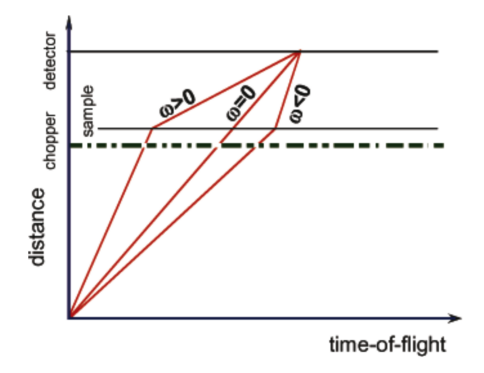

In [4]:
# Load the image
try:
    image = Image.open("Signal_w_cc.png") 
except FileNotFoundError:
    print("Error: Image file not found.")
except Exception as e:
    print(f"An error occurred: {e}")
else:
   
  # Display the image inline using matplotlib
  plt.figure(figsize=(6, 6))
  plt.imshow(image)
  plt.axis('off')  # Hide axes ticks and labels
  plt.show()

# Introduction

1. SCDS requires large reciprocal space with sufficient momentum and energy resolution

2. CC:

   Signal is not directly proportional to $S(Q, \omega)$, but for a fixed total TOF, it is the sum over all energy transfer $\omega$ for which the neutrons were allowed to pass the chopper

   reconstructed to get $S(Q, \omega)$. Use up to 50% of the incident beam spectrum. (>> 1-5% of a traditional TOF spectrometer)

    the statistical erros of the derived scattering function are now correlated among different channels leading to poor statistics for weak signals

    At pulsed source, the erros in the reconstructed $S(Q(\omega)$, $\omega)$ are only correlated along the energy transfer $\omega$ for a fixed energy transfer, $\omega$ is indepenent of the monenturm transfer $Q$
   

# McStas simulation

source + cc + sample + single point detector

high resolution water moderator

cc: r = 35 cm. f = 350 Hz and 255 elements, 19 m from the modeerator

sample: 1 m after cc; powder sample, a harmonic oscialltor with $\hbar \omega_0 = 2$ meV

detector: 1 cm x 1 cm, 2.5 m from sample

## Christina.instr

DEFINE COMPONENT StatisticalChopper

by Stephan Rosenkranz

parameters:

RChop (m): radius of chopper at the middle of opening
fChop (Hz): chopper frequency

NSeq: number of effective elements in CC, N=255
ChopSeq[NSeq] : pre-defined chopper element state
ChopperPhase

fsource: source frequency

==> TChop = NSeq/nSource/fsource   # number of source: is the nummber of mini-pulses in one main neutron pulse from the moderator
TChop: the period of CC,  Tchop = 1/fChop


TRACE
 %{
    double txy;
    int iseq;

    PROP_Z0;
    

    /* currently only for positive rotation sense */
    /* need to change sign in next line for positiv rotation */
    /* Notice: NSeq*wx is actually the Circumference of the Chopper! */

    txy = t - x*TChop / ( 2*PI*( RChop + y ) );      
    
    /* Random Phase offset */
    /* Notice NSource and NSeq have to be co-prime in order to sample all offsets */
    ChopperPhase = rint(rand01()*(NSeq-1));
    
   /* the PhaseOffset is only know to within one chopper element, i.e.
      the center of bin 0 is at x=0 not exactly at t=0, but anywhere
      between -1/2*Tc/N ... +1/2*Tc/N, so this introduces an uncertainty 
      in the determination of the Phase offset
      this is simply simulated by subtracting the uncertainty from txy
    */
  
     txy -= ( rand01() - 0.5 )*TChop/NSeq;
  
    /* Sequence-Element currently at x,y (where the neutron is) */
    
    iseq = (int)( rint( NSeq/TChop*txy ) - ChopperPhase ) % NSeq;
    if ( iseq < 0 ) iseq += NSeq;


    /* more accurately, need to include finite disc-thickness and absorption */
    if (!ChopSeq[iseq]) ABSORB;
    
    SCATTER;

 %}

t is the time when neutron arrives at the chopper position
txy: 
    - x*TChop / ( 2*PI*( RChop + y )): correction for fintie beam width
        the time offset since neutron might not at ideal beam postion (0, y)
        this is the time for the slit center moves from the center of the beam (0, y) to the actual neutron geposition (x, y)

ChopperPhase:
    pick a random chopper element as a reference ==> all elements will be sampled. 

## DEFINE COMPONENT TOF_monitor_color

parameters: tmin, nchan, dt

TOF_N[nchan+1][NSeq]:  2D dataset, number of raw counts
TOF_p[nchan+1][NSeq]:  2D dataset: number of weighted counts
TOF_p2[nchan+1][NSeq]:  2D dataset: number of weighted variance

tmin: minimum TOF on the detector
ChopperPhase: a variable to record the random phase shift of CC when the neutron passing it

This code is essential for components that simulate time-of-flight (TOF) experiments using pseudo-random choppers (PRCs) or other multiplexing techniques.

In a standard TOF experiment, a single pulse of neutrons is sent, and their arrival times are recorded. With a PRC, multiple neutron pulses (defined by the ChopSeq) are sent simultaneously, which allows for better use of the source and higher count rates. However, the raw TOF spectrum recorded by the detector (TOF_N, TOF_p, TOF_p2) is a convoluted signal.

Cross-correlation is a mathematical technique used to deconvolve this multiplexed signal. By cross-correlating the recorded detector signal with the known chopper sequence (ChopSeq), the original, single-pulse-equivalent TOF spectrum (intensity and error) can be recovered. This effectively allows for higher data rates and improved statistical precision compared to traditional single-pulse TOF methods.

Therefore, this SAVE block is vital for such components to produce meaningful scientific results for neutron scattering experiments using pseudo-random choppers.

# McStas components

StatisticalChopper, by Monzat, Farhi and Rozenkranz
StatisticalChopper_Monitor

R. Von Jan and R. Scherm. The statistical chopper for neutron time-of-flight spectroscopy. Nuclear Instruments and Methods, 80 (1970) 69-76.

# Load data from the case shown in Stephan's paper


- First use the default parameters used in the McStas code

    
    RChop = 0.26 m  # chopper diameter, center of the slit  
    L1 = 13.6 m     # source to sample
    L2 = 2.0 m      # sample to detector
    LCS = 1.0 m     # chopper to sample
    
    there is the ratio of the time seen by the chopper and the time seen by the detector for elastic scattering neturons. 
    
    (L1+L2)/(L1-LCS) = 

    The default setting used in the McStas file does not resolved the 2 meV excitation. 

- Update the instrument parameters to match Corelli's numbers
    
        for chopper freq of 350 Hz, R = 35 cm
        moderator to chopper = 19.0 m
        moderator to sample =  20.0 m
        sample to detector 2.5 m
        
    These parameters are chosen to match the 10 $\mu$s time resolution 

## About instrument

In [5]:
L1, L2, LCS= 20.0, 2.5, 1.0
fChop=350  #Hz
Nseq = 255  # slit number
fSource = 60 #Hz

TChop = 1/fChop
nSource = Nseq * fChop/fSource
TChop, nSource, TChop/Nseq*1e6

(0.002857142857142857, 1487.5, 11.204481792717088)

In [6]:
folder = "./cc3Monitor/cc/" #Corelli_20250605_153247/"

In [7]:
Icc = np.loadtxt(folder + "cc.dat")
#Errcc = np.loadtxt(folder + "ccerr.dat")
Icc[Icc<=0] = 1e-16
Icc.min(), Icc.max()

(1.209344357e-18, 2.131181915e-11)

## About the data

    binoffiset, index of the offseted TOF_detector bin in case of that  the detecot TOF starts from zero
    binfactor, in case of the TOF_detector has a better resolution than the statsical chopper
            = 1 , matching the chopper time resolutin
            = 2,  matching 1/2 of the chopper time resolutin

In [8]:
nTofbins, Nslits = Icc.shape
binfactor = 1
infostr = "10 meV, 300 K, n=5"

cc_p = 1/350*1e6      # period of cc 
dt_cc = cc_p/Nslits     # bin size of cc
dt_det = dt_cc * (L1+L2)/(L1-LCS)/binfactor   # tof binsize on detector
cc_det = dt_det * 2* 255 

binoffset = int(0/dt_det)

cc_p, dt_cc, cc_det, dt_det, Nslits, nTofbins

(2857.1428571428573,
 11.204481792717088,
 6766.917293233083,
 13.268465280849183,
 255,
 1275)

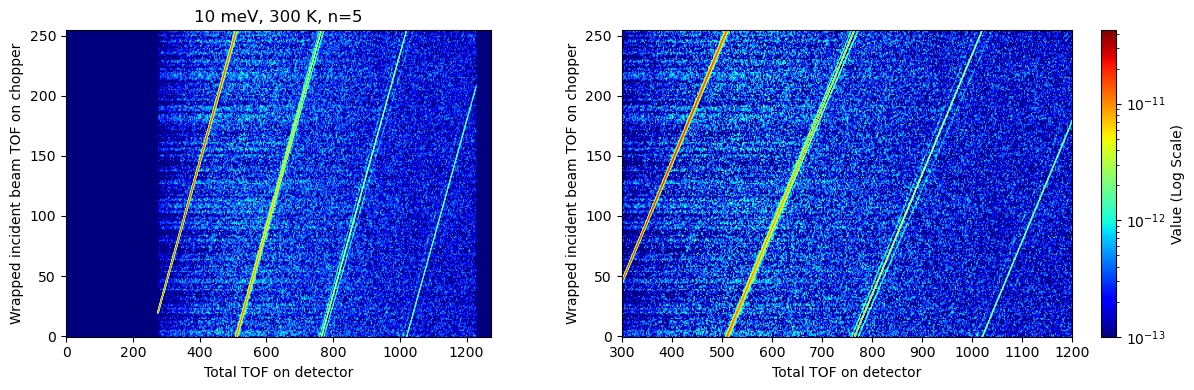

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12.8, 4))

im1= ax1.imshow(Icc.T, cmap='jet', norm=LogNorm(vmin=1e-13, vmax=Icc.max()*2), origin="lower")
#plt.colorbar(im1, label='Value (Log Scale)')
ax1.set_title(infostr)
ax1.set_aspect(3.6)

im2= ax2.imshow(Icc.T, cmap='jet', norm=LogNorm(vmin=1e-13, vmax=Icc.max()*2), origin="lower")
ax2.set_xlim(300, 1200)
ax2.set_aspect(2.4)
fig.colorbar(im2, label='Value (Log Scale)') #, shrink=0.8)

for ax in [ax1, ax2]:
    ax.set_ylabel('Wrapped incident beam TOF on chopper')
    ax.set_xlabel('Total TOF on detector')
plt.tight_layout()

#plt.ylim(12, 40)
#plt.savefig(folder+"../cc2_10meV_aftercc.png", dpi=200)

# convert tof bin indx into TOF and then convert to wavelegnth

In [10]:
tofmin = 0
tofmax = tofmin + dt_det*(nTofbins+1)
tof_wrap = cc_p *(L1+L2)/(L1-LCS)
print(dt_cc, dt_det, dt_cc*255, dt_det*255, tof_wrap, tofmax)

11.204481792717088 13.268465280849183 2857.1428571428573 3383.4586466165415 3383.4586466165415 16930.56169836356


(0.7, 2.8)

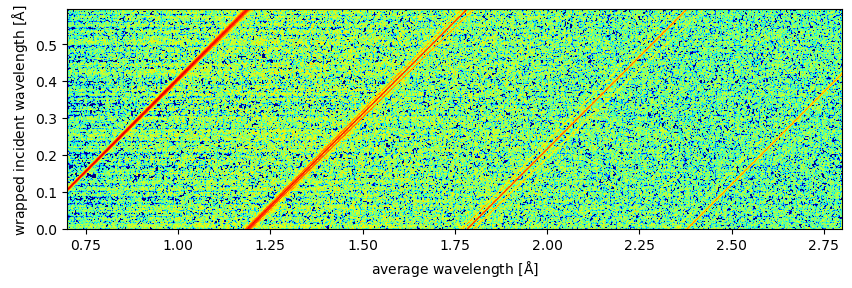

In [11]:
tof_i = np.linspace(tofmin+dt_det/2, tofmax-dt_det/2, nTofbins)
tof_i_b = np.linspace(tofmin, tofmax, nTofbins+1)

lambda_i_b = neutron_velocity_to_wavelength(22.5, tof_i_b/1e6)*1e10

tof_f = np.linspace(dt_det/2, dt_det*245.5, 255)
tof_f_b = np.linspace(0, dt_det*255, 255+1)
lambda_f_a_b = neutron_velocity_to_wavelength(22.5, tof_f_b/1e6)*1e10
lambda_f_b = neutron_velocity_to_wavelength(22.5, tof_f/1e6)*1e10

plt.figure(figsize=(10, 6))
plt.imshow(Icc.T, cmap='jet', norm=LogNorm(vmin=1e-15, vmax=Icc.max()*2), origin="lower", extent = [lambda_i_b.min(), lambda_i_b.max(), lambda_f_a_b.min(),lambda_f_a_b.max()])
plt.xlabel(r"average wavelength [$\rm \AA$]")
plt.ylabel(r"wrapped incident wavelength [${\rm \AA}$]")
plt.xlim(0.7, 2.8)

In [12]:
def create_periodic_diagonal_matrix(A, binfactor = 1, offset=0):
    """
    Converts an m x n with n columns) matrix A into an m x m matrix B,
    where m >> n, by periodically repeating the rows and columns of A.
    Then, it extracts the diagonal elements, setting all others to zero.

    Args:
        A (np.ndarray): The input matrix (m_rows_A x n_cols_A).
    
        offset: tof_min/tofbin define the number of binoffset 
   
    Returns:
        np.ndarray: The resulting m x m diagonal matrix B.
    """
    n, m = A.shape
    offset = int(offset)
    if offset < 0:
        raise ValueError("Negative TOF bin offset is not meanfuling")
    else:
        _m = m + offset
    if _m <= n:
        raise ValueError("m must be greater than n for periodic repetition to be meaningful.")
    

    # Step 1: Create the m x m matrix B_periodic by repeating A periodically.
    # B_periodic[i, j] = A[i % n, j % n]
    _m = int(_m/binfactor)
    B_periodic = np.zeros((_m, m))
    for i in range(_m):
        B_periodic[i, :] = A[i % n, :]

    # Step 2 (Optional/Contextual): Apply the effective width condition.
    # This step is relevant if you wanted a band-diagonal matrix first,
    # before extracting *only* the diagonal.
    floor_n_half = int(n*binfactor/2)
    #floor_n_half = (binfactor*n) // 2 # floor(n/2)
    B_diagonal = np.copy(B_periodic)
    for i in range(_m):
        for j in range(m):
            if abs(i*binfactor - offset - j) > floor_n_half:
                 B_diagonal[i, j] = 0
    
    # print("\nB_banded (if effective width was applied before diagonalizing):")
    # print(B_banded)
    #
    # If your final requirement is strictly diagonal, this step just shows an intermediate state.
    # The 'effective width' condition abs(i-j) > floor(n/2) for a *diagonal* element (i=j)
    # is 0 > floor(n/2), which is always false for n >= 1. So it doesn't filter diagonals.

    # Step 3: Keep only the diagonal values and set others to zero.
    # This will create a diagonal matrix.
    #B_diagonal = np.diag(np.diag(B_periodic)) # np.diag extracts the diagonal, then np.diag creates a diagonal matrix from it

    return B_diagonal



In [13]:
Icc_c = create_periodic_diagonal_matrix(Icc.T, binfactor=binfactor, offset = binoffset)
Icc_c.shape, binoffset, 

((1275, 1275), 0)

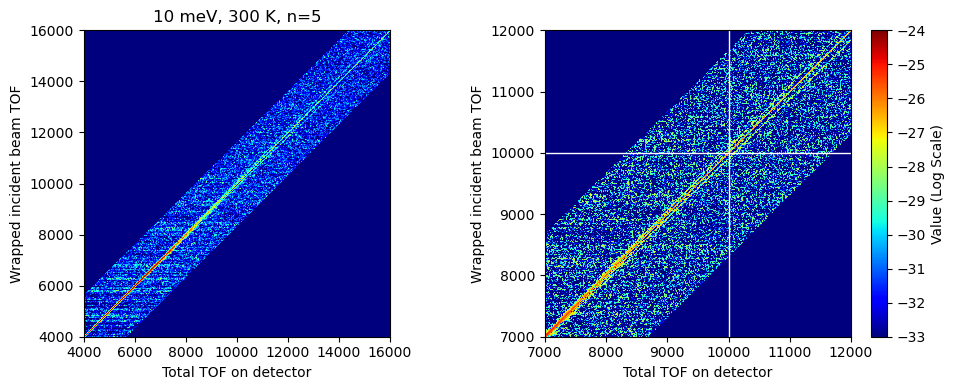

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))

im1= ax1.imshow(np.log(Icc_c+1e-19), cmap='jet', origin="lower", vmax=-25, vmin=-34, extent = [tofmin, tofmax, 0, tofmax])
ax1.set_title(infostr)
#ax1.set_aspect(3.6)
ax1.set_xlim(4000, 16000)
ax1.set_ylim(4000, 16000)
ax1.set_xlabel(r"TOF_detector ($\mu$s)")
ax1.set_ylabel(r"TOF_incident ($\mu$s)")

im2= ax2.imshow(np.log(Icc_c+1e-19), cmap='jet', origin="lower", vmax=-24, vmin=-33, extent = [tofmin, tofmax, 0, tofmax])
ax2.set_xlim(7000, 12000); ax2.set_ylim(7000, 12000)
#ax2.set_aspect(2.4)
fig.colorbar(im2, label='Value (Log Scale)') #, shrink=0.8)
ax2.vlines([10000], ymin=0, ymax = tofmax, lw=1, color='w')
ax2.hlines([10000], xmin=0, xmax = tofmax, lw=1, color='w')


for ax in [ax1, ax2]:
    ax.set_ylabel('Wrapped incident beam TOF')
    ax.set_xlabel('Total TOF on detector')
plt.tight_layout()


#plt.savefig(folder+"../cc2_2meV_aftercc.png", dpi=200)

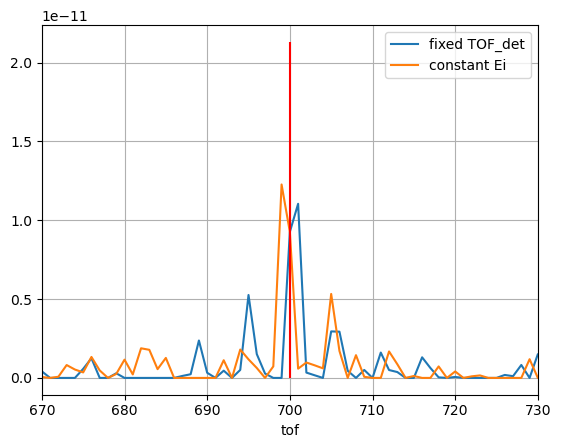

In [15]:
row = 700
col = int(row/binfactor)
plt.plot(Icc_c[:,row], label="fixed TOF_det")
plt.plot(Icc_c[col,:], label="constant Ei")
plt.legend(); 
plt.xlabel("tof")
plt.xlim(col*binfactor-30, col*binfactor+30)
plt.vlines([col*binfactor], ymin=0, ymax = Icc_c.max(), color='r')
plt.grid()

# convert to xarray data for axes transformation

In [16]:
print(Icc_c.shape)
nrow, ncol = Icc_c.shape

# --- Step 1: Define the coordinates for the *centers* of the grid cells ---
xb = np.linspace(0, tofmax, nrow+1)    #slit bin 
yb = np.linspace(0, tofmax, ncol+1)    #det bin

print(f"{dt_det=:5.2f} microseconds, {binfactor=:5.2f}")

xc = np.linspace(dt_det/2, tofmax-dt_det/2, nrow) 
yc = np.linspace(dt_det/2*binfactor, tofmax-(dt_det/2*binfactor), ncol)

xc.shape, yc.shape, xc.min(), xc.max(), xb.max()

(1275, 1275)
dt_det=13.27 microseconds, binfactor= 1.00


((1275,), (1275,), 6.6342326404245915, 16923.927465723136, 16930.56169836356)

In [17]:
# --- Step 3: Create the xarray DataArray using CENTER coordinates ---
# The indexed coordinates ('latitude', 'longitude') must have the same size as the data dims.
cc = xr.DataArray(
    Icc_c,
    coords={
        r'TOF_inc $\mu$s': xc,
        r'TOF_det $\mu$s': yc,
    },
    dims=[r'TOF_inc $\mu$s', r'TOF_det $\mu$s'],
    name='cc_data',
    attrs={
        'units': 'intensity',
        'long_name': 'cross correlation data',
        'description': 'TOF cross correlation data from a statstical chopper '
    }
)


(5000.0, 16000.0)

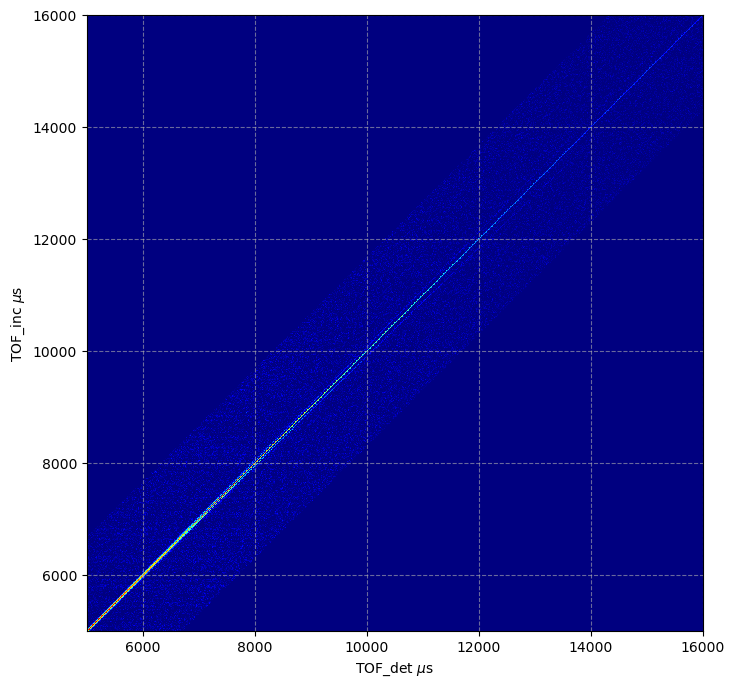

In [18]:
# --- Step 4: Visualize using plot.pcolormesh ---
# xarray's pcolormesh is smart and will infer the boundaries from the centers for plotting.
# The visual output will be correct, showing cells defined by boundaries.
plt.figure(figsize=(8, 8))
fig = cc.plot.pcolormesh(cmap='jet', add_colorbar=0)
plt.grid(True, linestyle='--', alpha=0.6)
ax = plt.gca()
ax.set_aspect(1)
plt.xlim(5000, 16000)
plt.ylim(5000, 16000)

## conversion function
- Icc is cross correlated time-of-flight (TOF) neutron scattering data.  x and y axes label the TOF (in microseconds) of the neutron events seen by the detector and the corresponding TOF of the incident neutrons. Let us name them the TOF_det, and TOF_inc, respectively.
- The source to the sample distance L1 is 20 m and the sample to the detector distance L2 =2.5 m, and the total TOF length L is 22.5 m.
- From the TOF of the incident neutrons and the total length L , we can calculate the neutron wavelength $\lambda_i$ and the incident wave vector $k_i$, and we can also calculate the TOF (let us call it TOF_source_2_sample) taken for neutrons flying from the source to the sample (length L1).
- Then the difference between TOF_det  and TOF_source_2_sample  is the TOF_sample_2_detector, from which we can calculate the wavelength $\lambda_f$, and the wave vector $k_f$ of the scatted neutrons.
- From $k_i$ and $k_f$, we can calculate the energy of the incident neutrons,  $E_i$ and the energy transfer $\Delta E$ in the scattering process.
- Save the data in two more data array, one recording ($k_i$, $k_f$) and one recording ($E_i$, $\Delta E$). 

In [19]:
def rebin(x_coords, y_coords, intensity, x_bins, xlims, y_bins, ylims, x_name, y_name):
    """
    Re-grids scattered data onto a regular 2D grid using binning.

    Args:
        x_coords (xr.DataArray): 2D array of x-coordinates for each intensity point.
        y_coords (xr.DataArray): 2D array of y-coordinates for each intensity point.
        intensity (xr.DataArray): 2D array of intensity values.
        x_bins (int): Number of bins for the new x-axis.
        y_bins (int): Number of bins for the new y-axis.
        x_name (str): Name for the new x-axis.
        y_name (str): Name for the new y-axis.

    Returns:
        xr.DataArray: A new DataArray containing the binned intensity on a regular grid.
    """
    # 1. Flatten all data and create a pandas DataFrame
    df = pd.DataFrame({
        'x': x_coords.values.ravel(),
        'y': y_coords.values.ravel(),
        'intensity': intensity.values.ravel()
    })

    # 2. Remove all unphysical points (where coordinates are NaN)
    df.dropna(inplace=True)

    # 3. Define the bins for the new regular grid
    x_ax_bins = np.linspace(xlims[0], xlims[1], x_bins + 1)
    y_ax_bins = np.linspace(ylims[0], ylims[1], y_bins + 1)


    # 4. Bin the data into the new grid
    df['x_binned'] = pd.cut(df['x'], bins=x_ax_bins)
    df['y_binned'] = pd.cut(df['y'], bins=y_ax_bins)

    # 5. Group by the new bins and sum the intensity in each bin
    # .sum() conserves total counts. Use .mean() for average intensity per bin.
    binned_intensity = df.groupby(['y_binned', 'x_binned'], observed=False)['intensity'].sum()

    # 6. Unstack the result to create a 2D grid
    binned_intensity_2d = binned_intensity.unstack(level='x_binned')

    # 7. Create new coordinate labels (the center of each bin)
    x_coords_new = (x_ax_bins[:-1] + x_ax_bins[1:]) / 2
    y_coords_new = (y_ax_bins[:-1] + y_ax_bins[1:]) / 2

    # 8. Create the final xarray DataArray
    result_da = xr.DataArray(
        data=binned_intensity_2d.values,
        coords={y_name: y_coords_new, x_name: x_coords_new},
        dims=[y_name, x_name]
    )

    return result_da

In [20]:
# --- Step 5: Using boundaries for coordinate transforms ---
# For a transformation, you would use the arrays you calculated in Step 2.
# For example, a hypothetical function might be called like this:
# --- Perform Calculations with Physical Constraint ---
t_inc = cc[r'TOF_inc $\mu$s'] * 1e-6
t_det = cc[r'TOF_det $\mu$s'] * 1e-6

lambda_i_min = 0.7
lambda_f_min = 0.5

v_i_max = 3956/lambda_i_min
v_f_max = 3956/lambda_f_min

v_i = (L1+L2) / t_inc
v_i = v_i.where(v_i < v_i_max)
t_source_to_sample = L1 / v_i
t_sample_to_detector = t_det - t_source_to_sample

# --- KEY CORRECTION: Apply the physical constraint ---
# Keep data only where the sample-to-detector time is positive.
# This will introduce NaNs in the unphysical regions.
#t_sample_to_detector = t_sample_to_detector.where(t_sample_to_detector > 0)
t_sample_to_detector = t_sample_to_detector.where(t_sample_to_detector > 5e-5)  

# The rest of the calculations will now correctly propagate the NaNs
v_f = L2 / t_sample_to_detector
v_f = v_f.where(v_f < v_f_max)
k_i = (2 * np.pi * NEUTRON_MASS_KG / H_PLANCK_JS) * v_i * 1e-10 # in 1/Angstrom
E_i = (0.5 * NEUTRON_MASS_KG * v_i**2) * J_to_meV
k_f = (2 * np.pi * NEUTRON_MASS_KG / H_PLANCK_JS) * v_f * 1e-10 # in 1/Angstrom
E_f = (0.5 * NEUTRON_MASS_KG * v_f**2) * J_to_meV
delta_E = E_i - E_f

# Broadcast E_i and k_i to be 2D arrays like the others
E_i_2d, _ = xr.broadcast(E_i, cc.T)
k_i_2d, _ = xr.broadcast(k_i, cc.T)

In [21]:
v_i.shape, v_f.shape

((1275,), (1275, 1275))

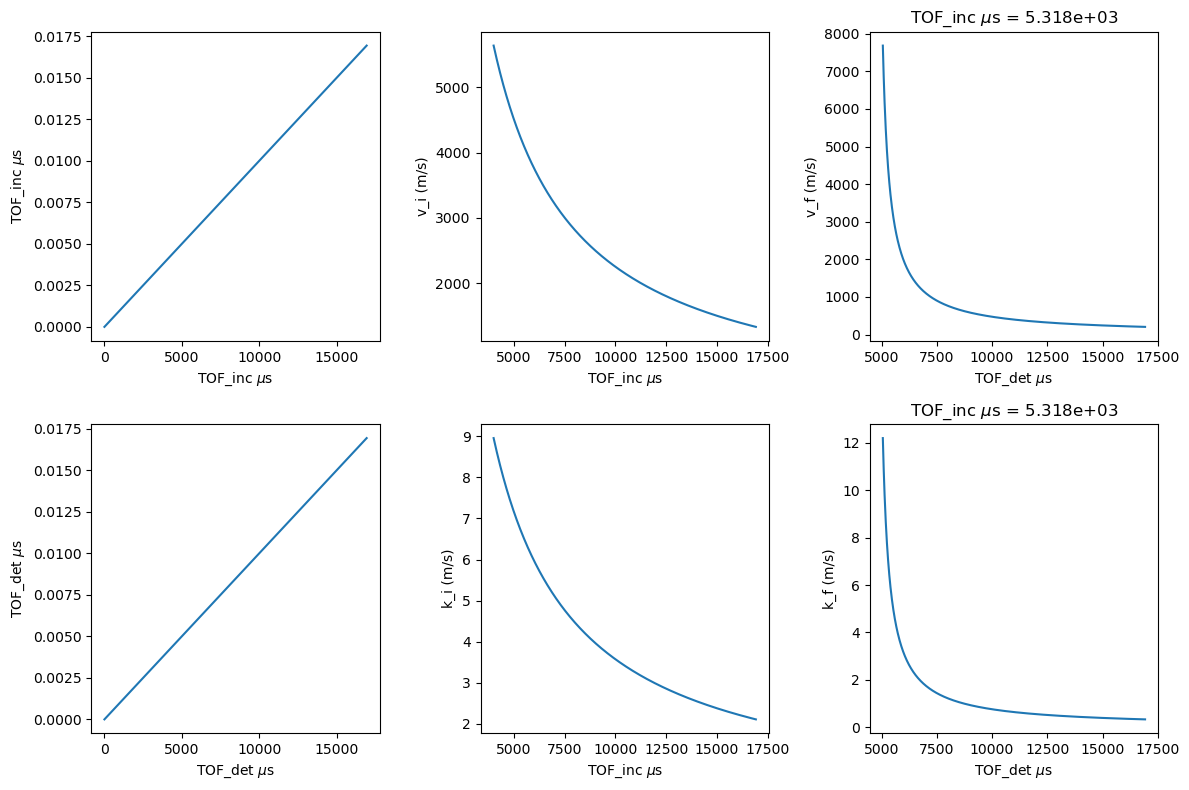

In [22]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(12, 8))
t_inc.plot(ax=ax1)
v_i.plot(ax=ax2); ax2.set_ylabel('v_i (m/s)')
v_f[:, 400].plot(ax=ax3); ax3.set_ylabel('v_f (m/s)')

t_det.plot(ax=ax4)
k_i.plot(ax=ax5); ax5.set_ylabel('k_i (m/s)')
k_f[:, 400].plot(ax=ax6); ax6.set_ylabel('k_f (m/s)')

plt.tight_layout()

In [23]:
k_i_2d.T.shape, k_f.shape, E_i_2d.shape, delta_E.shape

((1275, 1275), (1275, 1275), (1275, 1275), (1275, 1275))

In [50]:
# --- Transform to (ki, kf) space ---
# Define how many bins you want on the new axes
NUM_BINS_K = 200

cc_k_space = rebin(
    x_coords=k_i_2d,
    y_coords=k_f.T,
    intensity=cc,
    xlims = [0, 8], 
    ylims = [0, 8],
    x_bins=NUM_BINS_K,
    y_bins=NUM_BINS_K,
    x_name=r'$k_i$ ($\AA^{-1}$)',
    y_name=r'$k_f$ ($\AA^{-1}$)'
)


# --- Transform to (Ei, Delta E) space ---
# Define how many bins you want on the new axes
NUM_BINS_E = 30

cc_E_space = rebin(
    x_coords=E_i_2d,
    y_coords=delta_E,
    intensity=cc,
    xlims = [0, 60], 
    ylims = [-15, 15],
    x_bins=NUM_BINS_E,
    y_bins=NUM_BINS_E,
    x_name=r'$E_i$ (meV)',
    y_name=r'$\Delta E$ (meV)'
)

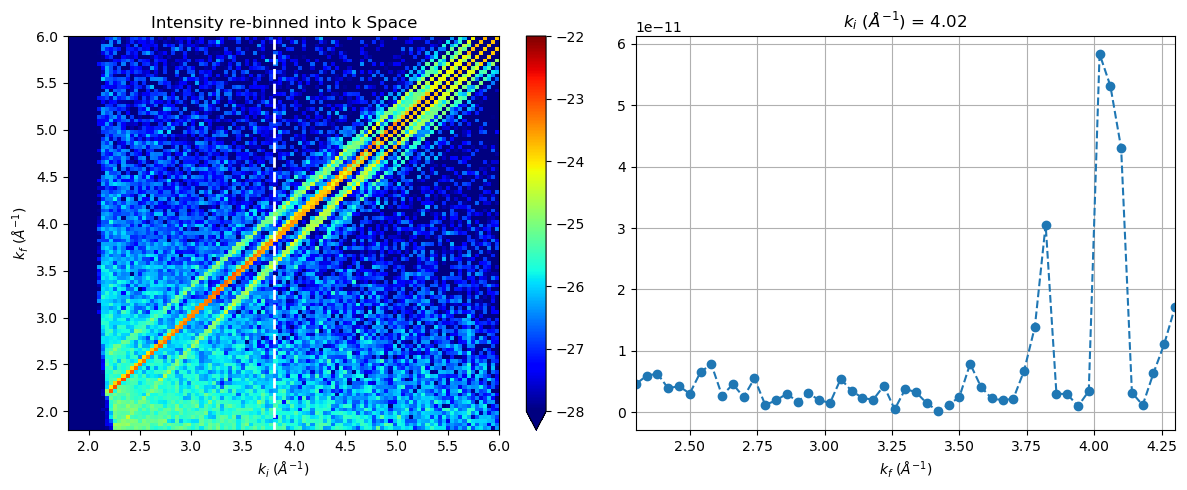

In [51]:
# --- Visualize one of the results ---
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12, 5))
np.log(cc_k_space+1e-15).plot.pcolormesh(cmap='jet', vmin=-28, vmax=-22, ax=ax1)
ax1.set_title('Intensity re-binned into k Space')
ax1.set_ylim(1.8, 6); ax1.set_xlim(1.8, 6)
#ax1.plot([0, 12], [0, 12])
ax1.vlines([3.81], ymin=0, ymax=6, ls="--", lw=2, color="w")

cc_k_space[:,100].plot(ax=ax2, marker="o", ls="--")
ax2.set_xlim(2.3, 4.3)
ax2.grid()

plt.tight_layout()

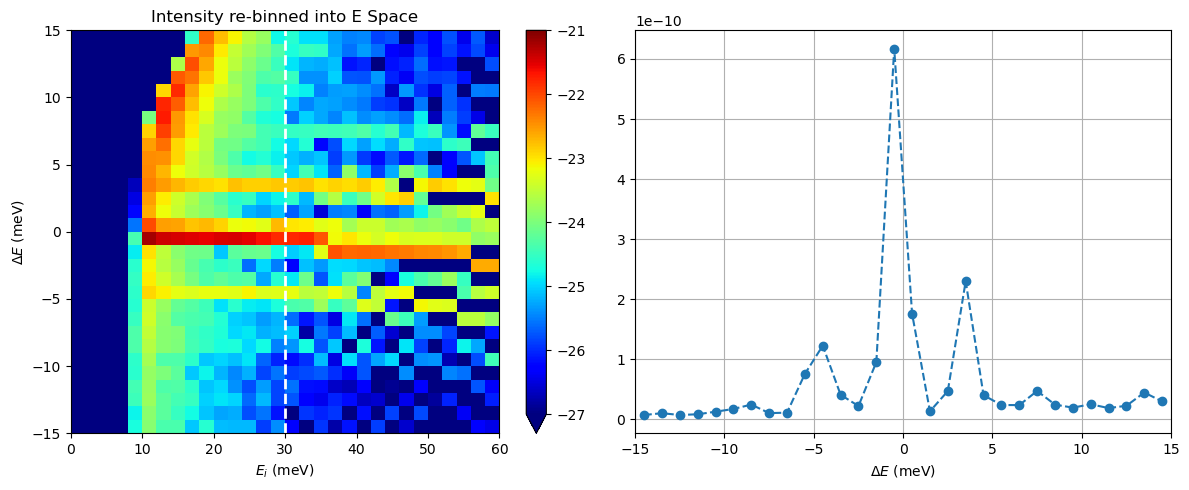

In [62]:
# --- Visualize one of the results ---
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12, 5))
np.log(cc_E_space+1e-15).plot.pcolormesh(cmap='jet', vmin=-27, vmax=-21, ax=ax1)
ax1.set_title('Intensity re-binned into E Space')
#ax1.set_ylim(-12, 12); ax1.set_xlim(20, 40)
#ax1.plot([0, 12], [0, 12])
ax1.vlines([30], ymin=-15, ymax=15, ls="--", lw=2, color="w")

(cc_E_space[:,16] + cc_E_space[:,17]).plot(ax=ax2, marker="o", ls="--")
ax2.set_xlim(-15, 15)
ax2.grid()

plt.tight_layout()

# Pre-cc data

Code to generate cc data

In [ ]:
TOFs = np.loadtxt("./cc2Monitor/Corelli_20250605_153247/Corelli.tof")

In [ ]:
nchan = int(TOFs.shape[0]/3)
I, dI, N = TOFs[:nchan, :], TOFs[nchan:2*nchan, :], TOFs[2*nchan:3*nchan, :]
I.max(), I.min(), dI.max(), dI.min(), N.max(), N.min()

In [ ]:
plt.figure(figsize=(12, 8))
#plt.imshow(I, cmap='viridis', vmin=I.min(), vmax=I.max(), origin="lower")
plt.imshow(np.log(I+1e-16), cmap='jet', vmin=-34, vmax=-24,  origin="lower", extent = [tofmin, tofmax, 0, 255])
#plt.colorbar(label='Value')
plt.title('Raw Data', fontsize=24)
plt.xlabel(r"TOF_detector ($\mu$s)", fontsize=24)
plt.ylabel('Time Dealy channel', fontsize=24)
plt.xlim(5000, 15000)
ax = plt.gca()
ax.set_aspect(20)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.tight_layout()
#plt.savefig(folder+"../2meV_beforecc.png", dpi=200)

In [ ]:
plt.figure(figsize=(12, 4))
plt.imshow(N, cmap='viridis', vmin=N.min(), vmax=N.max()*0.5, origin="lower")

plt.colorbar(label='Value')
plt.title('2D Image with Log Scale')
plt.ylabel('Time Dealy')
plt.xlabel('TOF')

## Reproduce the cc data from the saved TOF data and the chopper information

    mSeq = 0.0;
    for (i=0; i<NSeq; i++)  mSeq += (double)ChopSeq[i];
  
    cSeq = (mSeq-1.0)/( (double)NSeq-1.0);
    printf("mSeq = %g    cSeq = %.10g \n",mSeq, cSeq);
    fact = mSeq*(1.0-cSeq);
    //fprintf( CC_File, "#%10s %10s %10s %10s \n", "tofchan", "phasedealy", "intensity", "error");
    for (j=0; j<nchan; j++) {
      for (i=0; i<NSeq; i++) {
	    sump=0.0; sume2=0.0;
	    for (k=0; k<NSeq; k++ )
	    {
	      ik = i-k;
	      if ( ik < 0 ) ik += NSeq;
	      fact1 = ChopSeq[ik] - cSeq;
	      p1 = TOF_p[j][k];
	      sump += fact1*p1;
	      N = TOF_N[j][k];
	      if ( N > 1 )
	      {
	      	 fact3 = p1/N;
	         err2 = N/(N-1.0)*fabs(TOF_p2[j][k] - fact3*fact3);
	      }
	      else
	      {
	         err2 = p1*p1;
	      }

	      sume2 += fact1*fact1*err2;
	   }
	   CC_I = sump/fact;
	   fprintf( CC_IFile, "%.10g ", CC_I );
	   CC_e = sqrt(sume2)/fact;
	   fprintf( CC_eFile, "%.10g ", CC_e );
	   //fprintf( CC_File, "%11i %10i %.10g %.10g \n", j, i, CC_I, CC_e );
          }
	  fprintf( CC_IFile, "\n");
	  fprintf( CC_eFile, "\n");
    }
    fclose(CC_IFile);
    fclose(CC_eFile);
  }

In [ ]:
ChopSeq = "100000010101001101110010010011110111111001011000011101001010111100101011111011010011011111000100011011100010000010001101101010100001110111001011111011001110001100011011011110101010000000110000011110011010100101011100000001001101000111100010110110001100100"
NSeq = len(ChopSeq)
mSeq = ChopSeq.count('1')
cSeq = (mSeq-1.0)/(NSeq-1.0)
NSeq, mSeq, cSeq, nchan

In [ ]:
import math

def cc(ChopSeq, TOFs, cc_i_filename="CC_IFile.txt", cc_e_filename="CC_eFile.txt"):
    """
    Converts and processes time-of-flight (TOF) data similar to the provided C/C++ snippet.

    Args:
        ChopSeq (list or numpy.array): A sequence of values used in 'fact1' calculation.
        TOFs, the TOF data generated from McStas file, containing p, p2 and N
        cc_i_filename (str): Filename for the output file storing CC_I values.
        cc_e_filename (str): Filename for the output file storing CC_e values.
    """
    NSeq = len(ChopSeq)
    mSeq = ChopSeq.count('1')
    cSeq = (mSeq-1.0)/(NSeq-1.0)
    ChopSeq = np.array([int(char) for char in ChopSeq])
    
    nslit = int(TOFs.shape[0]/3)
    if NSeq != nslit:
        raise ValueError("Length of ChopSeq must match NSeq.")

    nchan = TOFs.shape[1]
    TOF_p, TOF_e, TOF_N = TOFs[:nslit, :], TOFs[nslit:2*nslit, :], TOFs[2*nslit:3*nslit, :]
    TOF_p2 = TOF_e**2

    #print(f"{NSeq=}, {nchan=}")
    
    # Calculate 'fact' outside the loops as it's constant
    fact = mSeq * (1.0 - cSeq)
 
    # Initialize two empty 2D lists to store the results
    cc_i_array = []
    cc_e_array = []

    for j in range(nchan):
        # Create empty rows for the current channel
        current_cc_i_row = []
        current_cc_e_row = []

        for i in range(NSeq):
            sump = 0.0
            sume2 = 0.0

            for k in range(NSeq):
                ik = i - k
                if ik < 0:
                    ik += NSeq

                fact1 = ChopSeq[ik] - cSeq
                p1 = TOF_p[k][j]
                sump += fact1 * p1

                N = TOF_N[k][j]
                err2 = 0.0

                if N > 1:
                    fact3 = p1 / N
                    err2 = (N / (N - 1.0)) * abs(TOF_p2[k][j] - fact3 * fact3)
                else:
                    err2 = p1 * p1

                sume2 += fact1 * fact1 * err2

            CC_I = sump / fact
            CC_e = math.sqrt(sume2) / fact

            # Append calculated values to the current row lists
            current_cc_i_row.append(CC_I)
            current_cc_e_row.append(CC_e)

        # Append the completed rows to the main 2D arrays
        cc_i_array.append(current_cc_i_row)
        cc_e_array.append(current_cc_e_row)

    return np.asarray(cc_i_array), np.asarray(cc_e_array)



def cc2(ChopSeq, TOFs, cc_i_filename="CC_IFile.txt", cc_e_filename="CC_eFile.txt"):
    """
    Converts and processes time-of-flight (TOF) data similar to the provided C/C++ snippet.

    Args:
        ChopSeq (list or numpy.array): A sequence of values used in 'fact1' calculation.
        TOFs, the TOF data generated from McStas file, containing p, p2 and N
        cc_i_filename (str): Filename for the output file storing CC_I values.
        cc_e_filename (str): Filename for the output file storing CC_e values.
    """
    NSeq = len(ChopSeq)
    mSeq = ChopSeq.count('1')
    cSeq = (mSeq-1.0)/(NSeq-1.0)
    ChopSeq = np.array([int(char) for char in ChopSeq])
    
    nslit, nchan = int(TOFs.shape[0]/3), TOFs.shape[1]
    if NSeq != nslit:
        raise ValueError("Length of ChopSeq must match NSeq.")

    #print(f"{NSeq=}, {nchan=}")
        
    TOF_p, TOF_e, TOF_N = TOFs[:nslit, :], TOFs[nslit:2*nslit, :], TOFs[2*nslit:3*nslit, :]
    TOF_p2 = TOF_e**2

   
    # Calculate 'fact' outside the loops as it's constant
    fact = mSeq * (1.0 - cSeq)
 
    # Initialize two 2D arrays with zeros based on known dimensions (nchan x NSeq)
    
    cc_i_array = np.zeros([NSeq, nchan])
    cc_e_array = np.zeros([NSeq, nchan])

    for j in range(nchan):
        for i in range(NSeq):
            sump = 0.0
            sume2 = 0.0

            for k in range(NSeq):
                ik = i - k
                if ik < 0:
                    ik += NSeq

                fact1 = ChopSeq[ik] - cSeq
                p1 = TOF_p[k][j]
                sump += fact1 * p1

                N = TOF_N[k][j]
                err2 = 0.0

                if N > 1:
                    fact3 = p1 / N
                    err2 = (N / (N - 1.0)) * abs(TOF_p2[k][j] - fact3 * fact3)
                else:
                    err2 = p1 * p1

                sume2 += fact1 * fact1 * err2

            CC_I = sump / fact
            CC_e = math.sqrt(sume2) / fact

            cc_i_array[i][j] = CC_I
            cc_e_array[i][j] = CC_e

    return cc_i_array, cc_e_array


In [ ]:
%%time
#cc_I, cc_e = cc(ChopSeq, TOFs)

In [ ]:
#cc_I[cc_I<=0]=cc_I.max()*1e-5

In [ ]:
cc_I = np.asarray(cc_I)
plt.figure(figsize=(12, 3))
#plt.imshow(cc_I.T, cmap='viridis', vmin=cc_I.min(), vmax=cc_I.max(), origin="lower")
plt.imshow(np.log(cc_I.T), cmap='jet', vmin=-35, origin="lower")
plt.colorbar(label='Value')
plt.title('2D Image')
plt.ylabel('Time dealy channel')
plt.xlabel('TOF bin')


In [ ]:
%%time
#cc2_I, cc2_e = cc2(ChopSeq, TOFs)

In [ ]:
cc2_I.shape, cc2_I.max(), cc2_I.min(), Icc.max(), Icc.min()

In [ ]:
plt.figure(figsize=(12, 3))
plt.imshow(cc2_I, cmap='viridis', vmin=cc2_I.min()*4, vmax=cc_I.max()*0.1, origin="lower")

plt.colorbar(label='Value')
plt.title('2D Image')
plt.ylabel('Time dealy channel')
plt.xlabel('TOF bin')

In [ ]:
print(Icc.min(), Icc.max())
plt.imshow(Icc.T, cmap='viridis', vmin=Icc.min()*4, vmax=Icc.max()*0.1, origin="lower")

In [ ]:
cc2_I[cc2_I<=0] = 1e-16
plt.imshow(cc2_I, cmap='viridis', vmin=cc2_I.min()*4, vmax=cc_I.max()*0.1, origin="lower")

In [ ]:
t_det.shape, t_source_to_sample.shape